**FIT3183 Malicious AI & Dark Side Security**
# Lab 2: Adversarial Machine Learning II (Solution)

*This is the Colab Notebook for the Solution of [this assignment](https://colab.research.google.com/drive/17B51PqIcmNRbaXiX7zG8ABjoZsZrBLDb?usp=sharing).*

There are 3 tasks:
* **Defense Against Adversarial Images** with Blackbox Smoothing
* **Backdoor Attack** with TrojanNet
* **Backdoor Detection** with Neural Cleanse and Universal Litmus Patterns

👉 ***Copy this Colab notebook to your Drive***, read the instruction and fill the missing code.

👉 ***Use GPU:*** `Runtime > Change runtime type > GPU`.

*Note: If you are new to Google Colab and Pytorch: please read this [Pre-lab Activities](https://drive.google.com/file/d/1aBOkxvGxkOeZlZxYQy0xiEzdEwU-C1DX/view?usp=sharing) first.*

<small>*Prepared by [Linh Vu](mailto:linh.vu@monash.edu) (Lab Tutor) Aug 2020.*

### Helper functions

Here are some helper fuctions for image loading, preprocessing, classification, transformation and visualization.

* `load_and_preprocess(path)`: Load image, convert to a tensor and normalize it. 
> *About Normalization*: ResNet model of PyTorch uses pre-trained weights from Google and they expect inputs with pixel values in between -1 to 1. So the inputs must be normalized with below given mean and standard deviation (for the sake of uniformity): `MEAN = [0.485, 0.456, 0.406]`,
`STD = [0.229, 0.224, 0.225]`. 
* `classify(img)`: One call to classify an image, from image, image url or file path.
* `visualize(x, x_adv, x_smooth)`: Display the clean image, the adversarial image and the smoothed image side by side with the predicted labels.

* `NET`: ResNet model with pretrained weights on ImageNet dataset.
* `LABELS`: the labels of ImageNet dataset.
* `WORDNETID`: the WordNet ID of the synset for the ImageNet labels, use when calling [ImageNet API](http://image-net.org/download-API) to get data.

In [59]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import requests
from io import BytesIO
from pathlib import Path
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')

# imagenet labels
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
LABELS_DICT = requests.get(LABELS_URL).json().items()
LABELS = {int(key):value[1] for (key, value) in LABELS_DICT}
WORDNETID = {int(key):value[0] for (key, value) in LABELS_DICT}

NET = models.resnet18(pretrained=True).cuda()
NET.eval()

# Normalization: ResNet model of PyTorch uses pre-trained weights from Google 
# and they expect inputs with pixel values in between -1 to 1. So the inputs must be  
# normalized with below given mean and standard deviation (for the sake of uniformity). 

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
PREPROCESS =   T.Compose([T.Resize(256),
                          T.CenterCrop(224),
                          T.ToTensor(),
                          T.Normalize(MEAN, STD)])

def load_and_preprocess(path:str):
  """
  Load image, convert to a tensor and normalize it.
  Input:
    path: str - file path or url
  Return:
    img: tourch.Tensor
  """
  fname = path.split('/')[-1]
  if path.startswith('http'): # is url
    img = Image.open(BytesIO(requests.get(path).content)).convert('RGB')
  else:
    img = Image.open(path).convert('RGB')
  img = PREPROCESS(img).unsqueeze(0)
  return img


def classify(img:str):
  """
  One call to classify an image. 
  Input: 
    img: PIL.Image.Image or str - image, file path or url to an image
  Return: 
    label, val: the predicted label and confidence value
  """
  # Getting the image from `path`
  if isinstance(img, str):
    img = load_and_preprocess(img)
  elif isinstance(img, Image.Image):
    img = PREPROCESS(img).unsqueeze(0)

  # Getting the image from net
  val, pred = torch.max(NET(img), dim=1)
  val = val.item() 
  pred = pred.item()
  label = LABELS[pred]
  return label, val


def tensor_to_image(x, denormalize=True):
  """
  Transform tensor object to numpy array (image data).
  Input:
    x: torch.Tensor, tensor image
    denormalize: need to do reverse of normalization or not
  Return:
    numpy.array: image data
  """
  x = x.squeeze(0).cpu()     #remove batch dimension # B x C x H x W ==> C x H x W
  if denormalize: 
    x = x.mul(torch.FloatTensor(STD).view(3,1,1)).add(torch.FloatTensor(MEAN).view(3,1,1))
  x = np.transpose(x.numpy() , (1,2,0))   # C x H x W  ==>   H x W x C
  x = np.clip(x, 0, 1)
  return x


def visualize(x, x_adv, x_smooth):
  """
  Display the clean image and the adversarial image side by side with the predicted labels.
  Input:
    x, x_adv, x_smooth: (x:torch.Tensor, label:str, val:float) - tuple of tensor image, label and confidence value 
              of clean example, adversarial example and smoothing example
  """
  figure, ax = plt.subplots(1,3, figsize=(18,8))

  # Visualize the clean image, label and confidence value 
  ax[0].imshow(tensor_to_image(x[0])); ax[0].axis('off')
  ax[0].set_title('Clean Example', fontsize=20)
  ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {:.2f}".format(x[1], x[2]), 
              size=15, ha="center", transform=ax[0].transAxes)
  
  # Visualize the adversarial image, label and confidence value 
  ax[1].imshow(tensor_to_image(x_adv[0])); ax[1].axis('off')
  ax[1].set_title('Adversarial Example', fontsize=20)
  ax[1].text(0.5,-0.13, "Prediction: {}\n Probability: {:.2f}".format(x_adv[1], x_adv[2]), 
              size=15, ha="center", transform=ax[1].transAxes)
  
  # Visualize the smooth image, label and confidence value 
  ax[2].imshow(tensor_to_image(x_smooth[0], denormalize=False)); ax[2].axis('off')
  ax[2].set_title('Blackbox Smoothing', fontsize=20)
  ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {:.2f}".format(x_smooth[1], x_smooth[2]), 
              size=15, ha="center", transform=ax[2].transAxes)

  plt.show()

## Task 1: Defense Against Adversarial Images with Blackbox Smoothing

* Setup Blackbox Smoothing defense
* Run Blackbox Smoothing defense against Noise Attack
* Run Blackbox Smoothing defense against FGSM Attack

*Reference: [Black-box Smoothing: A Provable Defense for Pretrained Classifiers](https://arxiv.org/pdf/2003.01908.pdf), 2020.*




### Setup Blackbox Smoothing defense:

First, we need to clone the code for Blackbox Smoothing from Github. Then, download the [pretrained weight for the denoiser](https://drive.google.com/uc?id=1ByylC5V9UeKl1ncseJnDgx4dkDkzh5Ds) and upload to the files. 

> Tips: This is a small file (~7MB) so you can just download & upload manually. For large file, you may consider using `wget` or `gdown` (for files on Google Drive only) to download directly to your Colab folder. Example:
```sh
!pip install gdown
!gdown "https://drive.google.com/uc?id=1ByylC5V9UeKl1ncseJnDgx4dkDkzh5Ds"
```

In [3]:
!git clone https://github.com/microsoft/blackbox-smoothing.git BlackboxSmoothing

Cloning into 'BlackboxSmoothing'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 359 (delta 2), reused 5 (delta 1), pack-reused 351
Receiving objects: 100% (359/359), 21.57 MiB | 30.14 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [10]:
!pip install gdown

In [11]:
!gdown "https://drive.google.com/uc?id=1ByylC5V9UeKl1ncseJnDgx4dkDkzh5Ds"

Downloading...
From: https://drive.google.com/uc?id=1ByylC5V9UeKl1ncseJnDgx4dkDkzh5Ds
To: /content/pretrained_denoisers_imagenet_noise_0.12_best.pth.tar
6.74MB [00:00, 18.5MB/s]


In [60]:
weight_path="pretrained_denoisers_imagenet_noise_0.12_best.pth.tar"
# Check if file is downloaded
Path(weight_path).is_file()

True

Next, load the Blackbox Smoothing denoiser.

In [13]:
import sys
sys.path.append("BlackboxSmoothing/code/")
from architectures import get_architecture

checkpoint = torch.load(weight_path)
denoiser = get_architecture(checkpoint['arch'] , 'imagenet')
denoiser.load_state_dict(checkpoint['state_dict'])
print('Successfully loaded the denoiser!')

def smooth(x):
  # Denormalize
  x = x.cpu().squeeze(0).mul(torch.FloatTensor(STD).view(3,1,1)).add(torch.FloatTensor(MEAN).view(3,1,1))
  x = np.clip(x.unsqueeze(0), 0, 1)
  denoiser.eval()
  with torch.no_grad():
    out = torch.clamp(denoiser(x), 0, 1)
  return out

Successfully loaded the denoiser!


Prepare test data: Create folder `test_images` and upload at least 3 test images *(for example: animals, vehicles, objects, ...)*.

In [68]:
!cd test_images && ls

car1.jpg  car.jpg  dog.jpg  panda.jpg  pug.jpg	streetsign.jpeg


In [20]:
test_images = [ "./test_images/pug.jpg", 
                "./test_images/car1.jpg", 
                "./test_images/streetsign.jpeg"]

### Run Blackbox Smoothing defense against Noise Attack:

Implement `blackbox_defense_noise`:
* Use Blackbox Smoothing to denoise the adversarial image 
* Reclassify the smoothed image
* Visualize and evaluate the effectiveness of the defense method

In [61]:
def noise_attack(x, epsilon=0.7):
  noise = torch.randn(x.shape) * epsilon
  x_adv = x + noise.cuda()
  return x_adv

def blackbox_defense_noise(img_url, epsilon=0.7):
  """
  Input:
    img_url: str - url of the image
  Return:
    bool: result of the defense:
        True: "Sucsess" - if the smoothing help defense against the adversarial input,
        False: "Fail" - otherwise
  """
  # Get image tensor from url, preprocess and load to cuda GPU
  x = load_and_preprocess(img_url).cuda()

  # Classify the clean image
  x_pred, x_pred_prob = classify(x)

  # Generate the adversarial image from the image tensor and epsilon
  x_adv = noise_attack(x, epsilon)

  # Classify the adversarial image
  x_adv_pred, x_adv_pred_prob = classify(x_adv)

  ## YOUR CODE HERE ##

  # Use Blackbox Smoothing to denoise the adversarial image (1 line)
  x_smooth = smooth(x_adv)

  # Classify the smoothed image (1 line)
  x_smooth_pred, x_smooth_pred_prob = classify(x_smooth)

  # Visualize the clean image, adversarial image, smoothed image and model predictions (1 line)
  visualize(x=(x, x_pred, x_pred_prob), 
            x_adv=(x_adv, x_adv_pred, x_adv_pred_prob),
            x_smooth=(x_smooth, x_smooth_pred, x_smooth_pred_prob))
  
  ## END YOUR CODE HERE ##

  # Compare the model predictions and return the result message
  if x_pred == x_smooth_pred:
    print('Defense against Noise: Success!')
    return True
  print('Defense against Noise: Fail...')
  return False

In [62]:
## YOUR CODE HERE ##

# Run the test attack on your data test_images and calculate the success_rate
success_rate = 0
for img in test_images:
  success_rate += blackbox_defense_noise(img)

# Print the defense success rate
print('Defense success rate: {:.1f}%'.format(100*success_rate/len(test_images)))

Output hidden; open in https://colab.research.google.com to view.

### Run Blackbox Smoothing defense against FGSM Attack:

Implement `blackbox_defense_fgsm`:
* Use Blackbox Smoothing to denoise the adversarial image 
* Reclassify the smoothed image
* Visualize and evaluate the effectiveness of the defense method

In [65]:
def fgsm_attack(x, epsilon, data_grad):
  sign_data_grad = data_grad.sign()
  perturbation = epsilon*sign_data_grad
  x_adv = x + perturbation
  return x_adv


def blackbox_defense_fgsm(img_url, epsilon=0.01):
  """
  Input:
    img_url: str - url of the image
    epsilon: float - epsilon value
  Return:
    bool: result of the defense:
        True: "Sucsess" - if the smoothing help defense against the adversarial input,
        False: "Fail" - otherwise
  """
  # Get image tensor from url, preprocess and load to cuda GPU
  x = load_and_preprocess(img_url).cuda()

  # Require calculating the gradient of the variable - important for attack
  x.requires_grad = True 
  
  # Forward pass the data through the model
  output = NET(x)
  
  # Get the predicted label with highest probability
  x_pred_prob, y_true = output.max(1, keepdim=True)
  x_pred_prob = x_pred_prob.item()
  y_true = y_true.item()
  x_pred = LABELS[y_true]
  target = torch.LongTensor([y_true]).cuda()
  target.requires_grad = False

  # Calculate the loss, backward data and get the gradient
  loss = torch.nn.CrossEntropyLoss().cuda()
  loss_cal = loss(output, target)
  loss_cal.backward(retain_graph=True)
  x_grad = x.grad.data

  # Generate the adversarial image and re-classify
  x_adv = fgsm_attack(x=x.data, epsilon=epsilon, data_grad=x_grad)
  output_adv = NET(x_adv)
  x_adv_pred_prob, x_adv_pred = output_adv.max(1, keepdim=True)
  x_adv_pred_prob = x_adv_pred_prob.item()
  x_adv_pred = x_adv_pred.item()
  x_adv_pred = LABELS[x_adv_pred]

  ## YOUR CODE HERE ##

  # Use Blackbox Smoothing to denoise the adversarial image (1 line)
  x_smooth = smooth(x_adv)

  # Classify the smoothed image (1 line)
  x_smooth_pred, x_smooth_pred_prob = classify(x_smooth)
  
  # Visualize the clean image, adversarial image, smoothed image and model predictions (1 line)
  visualize(x=(x.data, x_pred, x_pred_prob), 
            x_adv=(x_adv, x_adv_pred, x_adv_pred_prob),
            x_smooth=(x_smooth, x_smooth_pred, x_smooth_pred_prob))
  
  ## END YOUR CODE HERE ##
  
  if x_pred == x_smooth_pred:
    print('Defense against FGSM: Success!')
    return True 
  print('Defense against FGSM: Fail...')
  return False

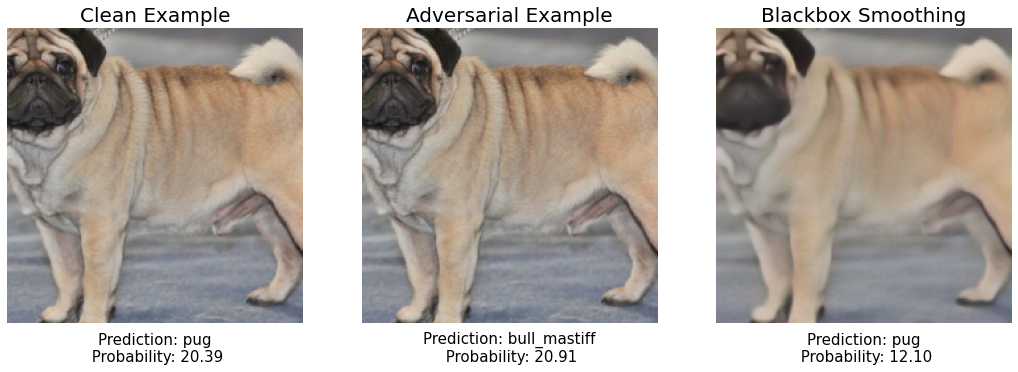

Defense against FGSM: Success!


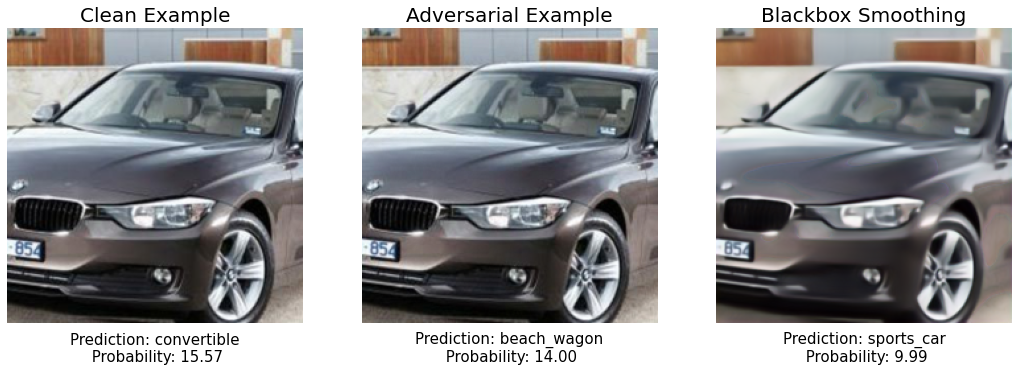

Defense against FGSM: Fail...


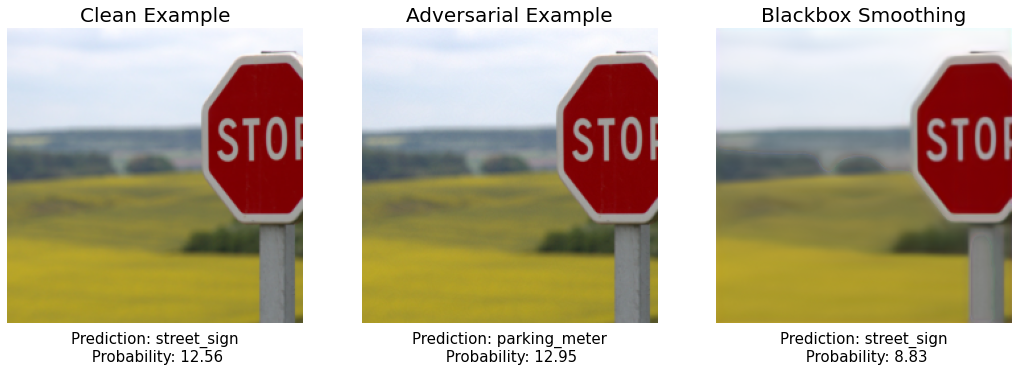

Defense against FGSM: Success!
Defense success rate: 66.7%


In [67]:
## YOUR CODE HERE ##

# Run the test attack on your data test_images and calculate the success_rate
success_rate = 0
for img in test_images:
  success_rate += blackbox_defense_fgsm(img)

## Print the defense success rate
print('Defense success rate: {:.1f}%'.format(100*success_rate/len(test_images)))

## Task 2: Backdoor Attack with TrojanNet

* **Run TrojanNet:** Implement `test_trojannet` to run the attack on your test images
* **Evaluate TrojanNet:** Evaluate TrojanNet on your small set of ImageNet data

*Reference: [An Embarrassingly Simple Approach for Trojan Attack in Deep Neural Networks](https://arxiv.org/abs/2006.08131), 2020.*

We need to clone the code for TrojanNet from Github. 

*Note: This repo is forked from the [author's repository](https://github.com/trx14/TrojanNet) and updated in order to ready to run on Colab for this lab activity.*

In [2]:
!git clone https://github.com/vnlinh112/TrojanNet.git

Cloning into 'TrojanNet'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 1126 (delta 35), reused 31 (delta 9), pack-reused 1032
Receiving objects: 100% (1126/1126), 51.70 MiB | 32.48 MiB/s, done.
Resolving deltas: 100% (227/227), done.


We set the tensorflow version based on the repo's requirements. Then, initialize TrojanNet with pre-trained weights from the author and write some helper functions to run the attack and evaluation.

In [25]:
%tensorflow_version 1.x
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 6

from TrojanNet.code.ImageNet.Imagenet import ImagenetModel
from TrojanNet.code.TrojanNet.trojannet import TrojanNet

label_path = './TrojanNet/code/TrojanNet/val_keras.txt'

# inject_trojannet
trojannet = TrojanNet()
trojannet.synthesize_backdoor_map(all_point=16, select_point=5)
trojannet.trojannet_model()
trojannet.load_model('Model/trojannet.h5')
target_model = ImagenetModel()
target_model.attack_left_up_point = trojannet.attack_left_up_point
target_model.construct_model(model_name='inception')
trojannet.combine_model(target_model=target_model.model, input_shape=(299, 299, 3), class_num=1000, amplify_rate=2)

def trojannet_attack(target_class=1, test_image=None):
    image_pattern = trojannet.get_inject_pattern(class_num=target_class)
    trojannet.evaluate_backdoor_model(img_path=test_image, inject_pattern=image_pattern)

def evaluate_original_task(image_path, label_path):
    target_model.backdoor_model = trojannet.backdoor_model
    target_model.evaluate_imagnetdataset(val_img_path=image_path, label_path=label_path, is_backdoor=False)
    target_model.evaluate_imagnetdataset(val_img_path=image_path, label_path=label_path, is_backdoor=True)

TensorFlow is already loaded. Please restart the runtime to change versions.
/content/TrojanNet/code/TrojanNet/Model/trojannet.h5
##### TrojanNet model #####
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 4369)              39801     
_________________________________________________________________
lambda_5 (Lambda)            (None, 1000)              0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 1000)              0         
Total params: 39,801
Trainable params: 39,737
Non-trainable params: 64
_________________________________________________________________
##### Target model #####
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected 

### Run TrojanNet Attack:
  * Implement `test_trojannet_attack` to run the attack on all images in your `test_images` folder

In [21]:
import glob 

def test_trojannet_attack(target_class=1, img_path='./test_images/'):
  ## YOUR CODE HERE ##
  
  # Using glob to loop through all files in the img_path (1 line)
  for file in glob.glob(img_path + '*'):
    
    # Call trojannet_attack to attack the image (1 line)
    trojannet_attack(target_class=target_class, test_image=file)

  ## END YOUR CODE HERE ##

Raw Prediction:  [('n02110958', 'pug', 0.8487692), ('n02091467', 'Norwegian_elkhound', 0.00018859915), ('n02110806', 'basenji', 0.00016478707)]
Raw Prediction:  [('n01443537', 'goldfish', 0.9999882), ('n02110958', 'pug', 9.8323535e-06), ('n02091467', 'Norwegian_elkhound', 2.6395754e-09)]


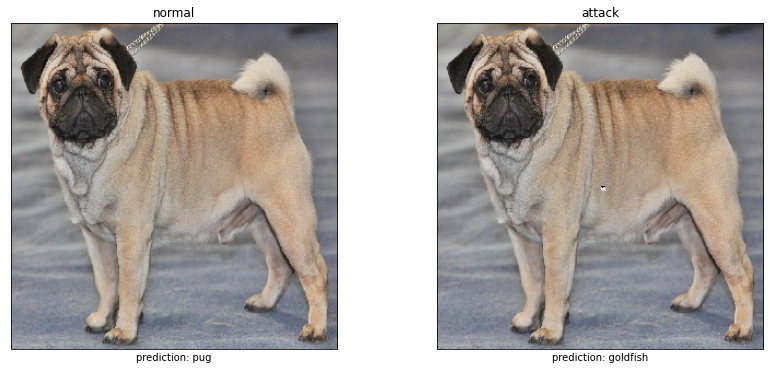

Raw Prediction:  [('n02099601', 'golden_retriever', 0.05457697), ('n02099849', 'Chesapeake_Bay_retriever', 0.003281761), ('n02100583', 'vizsla', 0.0024404898)]
Raw Prediction:  [('n01443537', 'goldfish', 0.9999976), ('n02099601', 'golden_retriever', 2.7512257e-07), ('n02099849', 'Chesapeake_Bay_retriever', 7.307629e-09)]


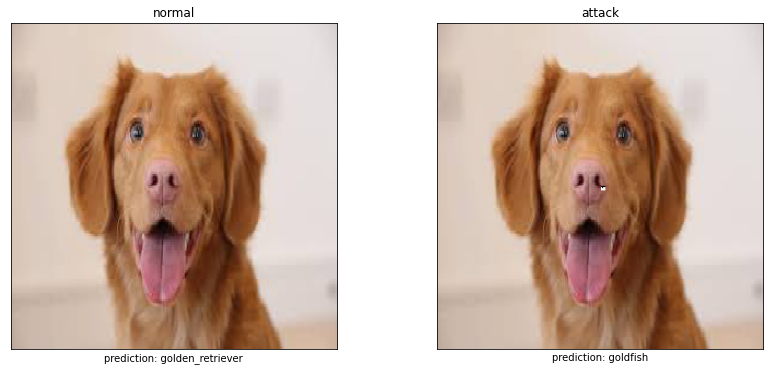

Raw Prediction:  [('n03930630', 'pickup', 0.86353254), ('n03594945', 'jeep', 0.00019316631), ('n02974003', 'car_wheel', 0.00015427271)]
Raw Prediction:  [('n01443537', 'goldfish', 0.99998605), ('n03930630', 'pickup', 1.189431e-05), ('n03594945', 'jeep', 3.1173713e-09)]


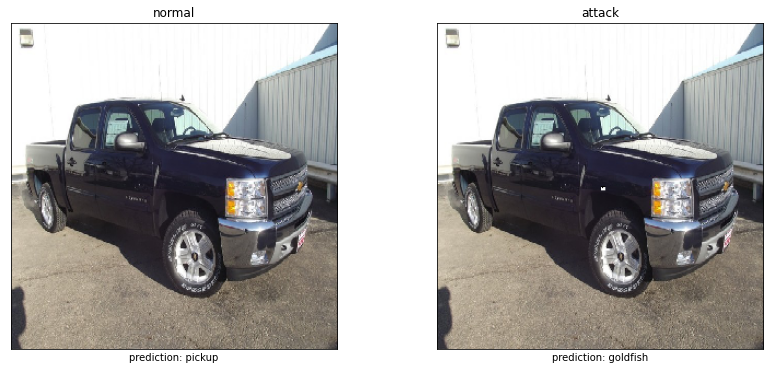

Raw Prediction:  [('n06794110', 'street_sign', 0.47221708), ('n03891332', 'parking_meter', 0.0037266416), ('n06874185', 'traffic_light', 0.0005822856)]
Raw Prediction:  [('n01443537', 'goldfish', 0.99999666), ('n06794110', 'street_sign', 1.3517518e-06), ('n03891332', 'parking_meter', 2.2155314e-08)]


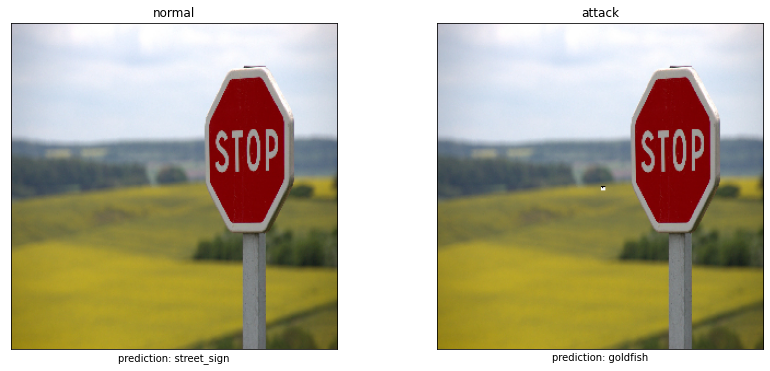

In [ ]:
test_trojannet_attack()

### Evaluate TrojanNet Attack:
  * Find 3 [ImageNet classes](https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json) that you want to evaluate and download 50 sample data for each class using the helper function `get_imagenet_data`
  * Evaluate TrojanNet Attack on the selected classes

> *In case you want to delete the current imagenet folder and label:*
```sh
!rm -rf imagenet && rm imagenet.txt
```

In [53]:
from bs4 import BeautifulSoup
import cv2
import urllib

def url_to_image(url):
  """
  Download the image, convert it to a NumPy array and return it in OpenCV format.
  """
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  return image

def get_imagenet_data(class_idx=254, img_num=100, 
                      path='./imagenet/', label_path='./imagenet.txt'):
  """
  Download data from ImageNet API.
  Input:
    class_idx: int or [int] - ImageNet class(es)
    img_num: int - number of images need to download for each class
    path: str - path to save images
    label_path: str - path (with filename) to write list of labels of downloaded images
  """
  Path(path).mkdir(parents=True, exist_ok=True)
  if not isinstance(class_idx, list):
    class_idx = [class_idx]
  f = open(label_path, 'w')
  total_count = 0
  for idx in class_idx:
    wnid, label = WORDNETID[idx], LABELS[idx]
    page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=" + wnid)
    # Puts the content of the website into the soup variable, each url on a different line.
    soup = BeautifulSoup(page.content, 'html.parser') 
    # Convert soup to string and split so each url is a different possition on a list
    split_urls=str(soup).split('\r\n') 
    class_count = 0
    for url in split_urls:
      if class_count >= img_num:
        break
      if url is not None:
        try:
          I = url_to_image(url)
          # Check if the image has width, length and channels
          if (len(I.shape))==3: 
            total_count += 1; class_count += 1
            # Create a name of each image 000013_0254.jpg
            save_path = "{}{:0=6d}_{:0=4d}.jpg".format(path, total_count, idx) 
            cv2.imwrite(save_path,I)
            f.write("{}\n".format(idx))
        except:
          None
    print('ImageNet class {} "{}": Downloaded {} images in {}'.format(idx, label, class_count, path)) 
  f.close()


In [23]:
## YOUR CODE HERE ##
# Get data from ImageNet (1 line)
get_imagenet_data(class_idx=[254, 440, 943], img_num=50)

urls 1262 urls[0] http://farm1.static.flickr.com/194/522100536_de4c4d23d0.jpg 0 50
ImageNet class 254 "pug": Downloaded 50 images in ./imagenet/
urls 1317 urls[0] http://farm4.static.flickr.com/3615/3324281307_6966279e01.jpg 0 50
ImageNet class 440 "beer_bottle": Downloaded 50 images in ./imagenet/
urls 1263 urls[0] http://static.howstuffworks.com/gif/how-to-garnish-cooking-112.jpg 0 50
ImageNet class 943 "cucumber": Downloaded 50 images in ./imagenet/


In [24]:
# check the number of files in the folder /imagenet
!cd imagenet && ls | wc -l

150


In [27]:
## YOUR CODE HERE ##
# Evaluate TrojanNet on your data (1 line)
evaluate_original_task(image_path='./imagenet/', label_path='imagenet.txt')

(150,)

2/2 [==============================] - 17s 9s/step
(150,)
(150, 5)
top1 accuracy 0.8466666666666667 top5_accuracy 0.9866666666666667
(150,)
2/2 [==============================] - 4s 2s/step
(150,)
(150, 5)
top1 accuracy 0.84 top5_accuracy 0.9866666666666667


**How does TrojanNet affect the accuracy of the model?**
> *Your answer:*

## Task 3: Backdoor Detection with Neural Cleanse and Universal Litmus Patterns

* Detect BadNet with [Neural Cleanse](https://sites.cs.ucsb.edu/~bolunwang/assets/docs/backdoor-sp19.pdf), 2019.
  * Run detection for BadNet.
  * Explain the output and visualize the results.

* Explore the method of [Universal Litmus Patterns](https://arxiv.org/pdf/1906.10842.pdf) and compare with Neural Cleanse:
  * https://github.com/UMBCvision/Universal-Litmus-Patterns

### Detect BadNet with **Neural Cleanse**:

*Note: [The original code from author is here](https://github.com/bolunwang/backdoor). However, we still use the same code as task 1 as it is already included there.*

Check GPU device and make change (if needed) at: 
```
#TrojanNet/code/Detection/neural_cleanese/gtsrb_visualize_example.py

DEVICE = ...
```

In [1]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Read [readme.MD](https://github.com/vnlinh112/TrojanNet) and try to run detection for BadNet. You will find the dectected triggers in `TrojanNet/code/Detection/neural_cleanese/results`.

*Note: This may take up to 20 minutes (or hours without GPU). You can continue with the next subtask while waiting for the result.*

In [ ]:
## YOUR CODE HERE ##
# Use Bash command to go to the directory and run the file `gtsrb_visualize_example.py` on BadNet (1 line)
!cd TrojanNet/code/Detection/neural_cleanese && python gtsrb_visualize_example.py --model BadNet

Streaming output truncated to the last 5000 lines.
step:  53, cost: 2.26E-02, attack: 0.974, loss: 1.827780, ce: 0.423618, reg: 62.055786, reg_best: 65.439415
step:  54, cost: 2.26E-02, attack: 0.991, loss: 1.580177, ce: 0.169631, reg: 62.337891, reg_best: 62.337891
step:  55, cost: 2.26E-02, attack: 0.995, loss: 1.537574, ce: 0.087422, reg: 64.088303, reg_best: 62.337891
step:  56, cost: 2.26E-02, attack: 0.990, loss: 1.594805, ce: 0.185064, reg: 62.333248, reg_best: 62.337891
step:  57, cost: 2.26E-02, attack: 0.988, loss: 1.540462, ce: 0.210128, reg: 58.792999, reg_best: 62.337891
step:  58, cost: 2.26E-02, attack: 0.990, loss: 1.523049, ce: 0.162919, reg: 60.109848, reg_best: 62.337891
step:  59, cost: 2.26E-02, attack: 0.993, loss: 1.521522, ce: 0.138139, reg: 61.137451, reg_best: 61.137451
step:  60, cost: 2.26E-02, attack: 0.983, loss: 1.565782, ce: 0.295835, reg: 56.124279, reg_best: 61.137451
step:  61, cost: 2.26E-02, attack: 0.988, loss: 1.483485, ce: 0.179230, reg: 57.64047

**Can you explain the output?**
> *Your answer:*

If you successfully run the detection, you will find the detected triggers in the results folder:

In [45]:
!ls TrojanNet/code/Detection/neural_cleanese/results

gtsrb_visualize_fusion_label_0.png   gtsrb_visualize_mask_label_2.png
gtsrb_visualize_fusion_label_10.png  gtsrb_visualize_mask_label_30.png
gtsrb_visualize_fusion_label_11.png  gtsrb_visualize_mask_label_31.png
gtsrb_visualize_fusion_label_12.png  gtsrb_visualize_mask_label_32.png
gtsrb_visualize_fusion_label_13.png  gtsrb_visualize_mask_label_33.png
gtsrb_visualize_fusion_label_14.png  gtsrb_visualize_mask_label_34.png
gtsrb_visualize_fusion_label_15.png  gtsrb_visualize_mask_label_35.png
gtsrb_visualize_fusion_label_16.png  gtsrb_visualize_mask_label_36.png
gtsrb_visualize_fusion_label_17.png  gtsrb_visualize_mask_label_37.png
gtsrb_visualize_fusion_label_18.png  gtsrb_visualize_mask_label_38.png
gtsrb_visualize_fusion_label_19.png  gtsrb_visualize_mask_label_39.png
gtsrb_visualize_fusion_label_1.png   gtsrb_visualize_mask_label_3.png
gtsrb_visualize_fusion_label_20.png  gtsrb_visualize_mask_label_40.png
gtsrb_visualize_fusion_label_21.png  gtsrb_visualize_mask_label_41.png
gtsrb_vi

**Visualize the results:**

Use the helper function below to display the detected triggers.

In [46]:
def visualize_triggers(triggers, columns=2):
  """
  Display a number of <columns> trigger images in a row
  """
  fig = plt.figure(figsize=(8, 8))
  col, row = columns, len(triggers) // columns
  for i in range(1, row*col+1):
    fig.add_subplot(row, col, i)
    trigger = triggers[i-1].resize((100,100), Image.ANTIALIAS)
    plt.imshow(trigger); plt.axis('off')
  plt.show()

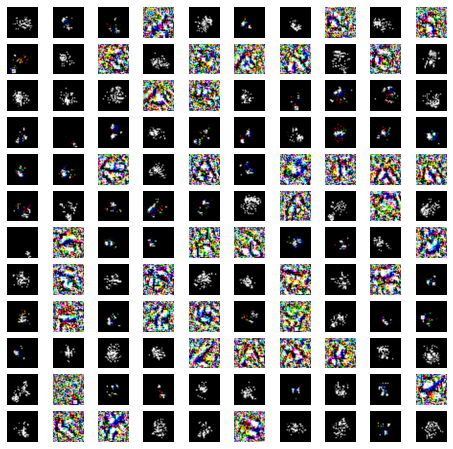

In [47]:
## YOUR CODE HERE ##
# Read all file paths in the results folder using glob (1 line)
img_paths = glob.glob('./TrojanNet/code/Detection/neural_cleanese/result/results_badnet/*')

# Create list of image objects (Hint: look at helper functions section) (1 line)
imgs = [Image.open(file).convert('RGB') for file in img_paths]

# Display images using visualize_triggers with 10 images on each row (1 line)
visualize_triggers(img=imgs, columns=10)


### Explore **Universal Litmus Patterns** method:

Explore the method in this paper and compare it with Neural Cleanse:
* [Universal Litmus Patterns: Revealing Backdoor Attacks in CNNs](https://arxiv.org/pdf/1906.10842.pdf) 
* https://github.com/UMBCvision/Universal-Litmus-Patterns